# Offline Calculation

An example using the `downscale.allocate` module to downscale 12 km emissions to a finer 4 km grid, based on the spatial structure of existing 4 km emissions. 

## Imports

In [1]:
import xarray as xr

from downscaler.utils.cmaq import get_cmaq_metadata, get_cmaq_projection
from downscaler.utils.xarray import update_datetime_year
from downscaler.allocate.allocate import (
    downscale_coarse_emissions,
    coarsen_finescale_emissions,
)

## Read Data

In [2]:
filename_fine = "../sandbox_data/emis_mole_rwc_20170601_4LMOS3_2017gb_4km_17j.ncf"
filename_coarse = (
    "../sandbox_data/emis_mole_rwc_20210601_12US1_cmaq_cb6ae7_2021hb_cb6_21k.ncf"
)

# Note that datasets are associated with different years, so update to use the
# same year for easier comparison.

updated_year = 1901
data_fine = update_datetime_year(
    get_cmaq_metadata(xr.open_dataset(filename_fine)), updated_year=updated_year
)

data_coarse = update_datetime_year(
    get_cmaq_metadata(xr.open_dataset(filename_coarse)), updated_year=updated_year
)


proj_fine = get_cmaq_projection(data_fine)
proj_coarse = get_cmaq_projection(data_coarse)

## Perform Downscaling

In [9]:
%%time

field = "NO2"

da_fine = data_fine[field].isel(LAY=0)
da_coarse = da_coarse = data_coarse[field].isel(LAY=0)

da_dscale = downscale_coarse_emissions(
    da_fine=da_fine,
    da_coarse=da_coarse,
    proj_fine=proj_fine,
    proj_coarse=proj_coarse,
    grid_factor=3,
)

CPU times: user 40.4 ms, sys: 8.85 ms, total: 49.2 ms
Wall time: 269 ms


For comparison purposes, upscale the fine-scale emissions to the coarse grid

In [4]:
da_upscale = coarsen_finescale_emissions(
    da_fine=da_fine,
    grid_factor=3,
)

## Visualize Output

In [5]:
import matplotlib.pyplot as plt
import cartopy.feature as cf

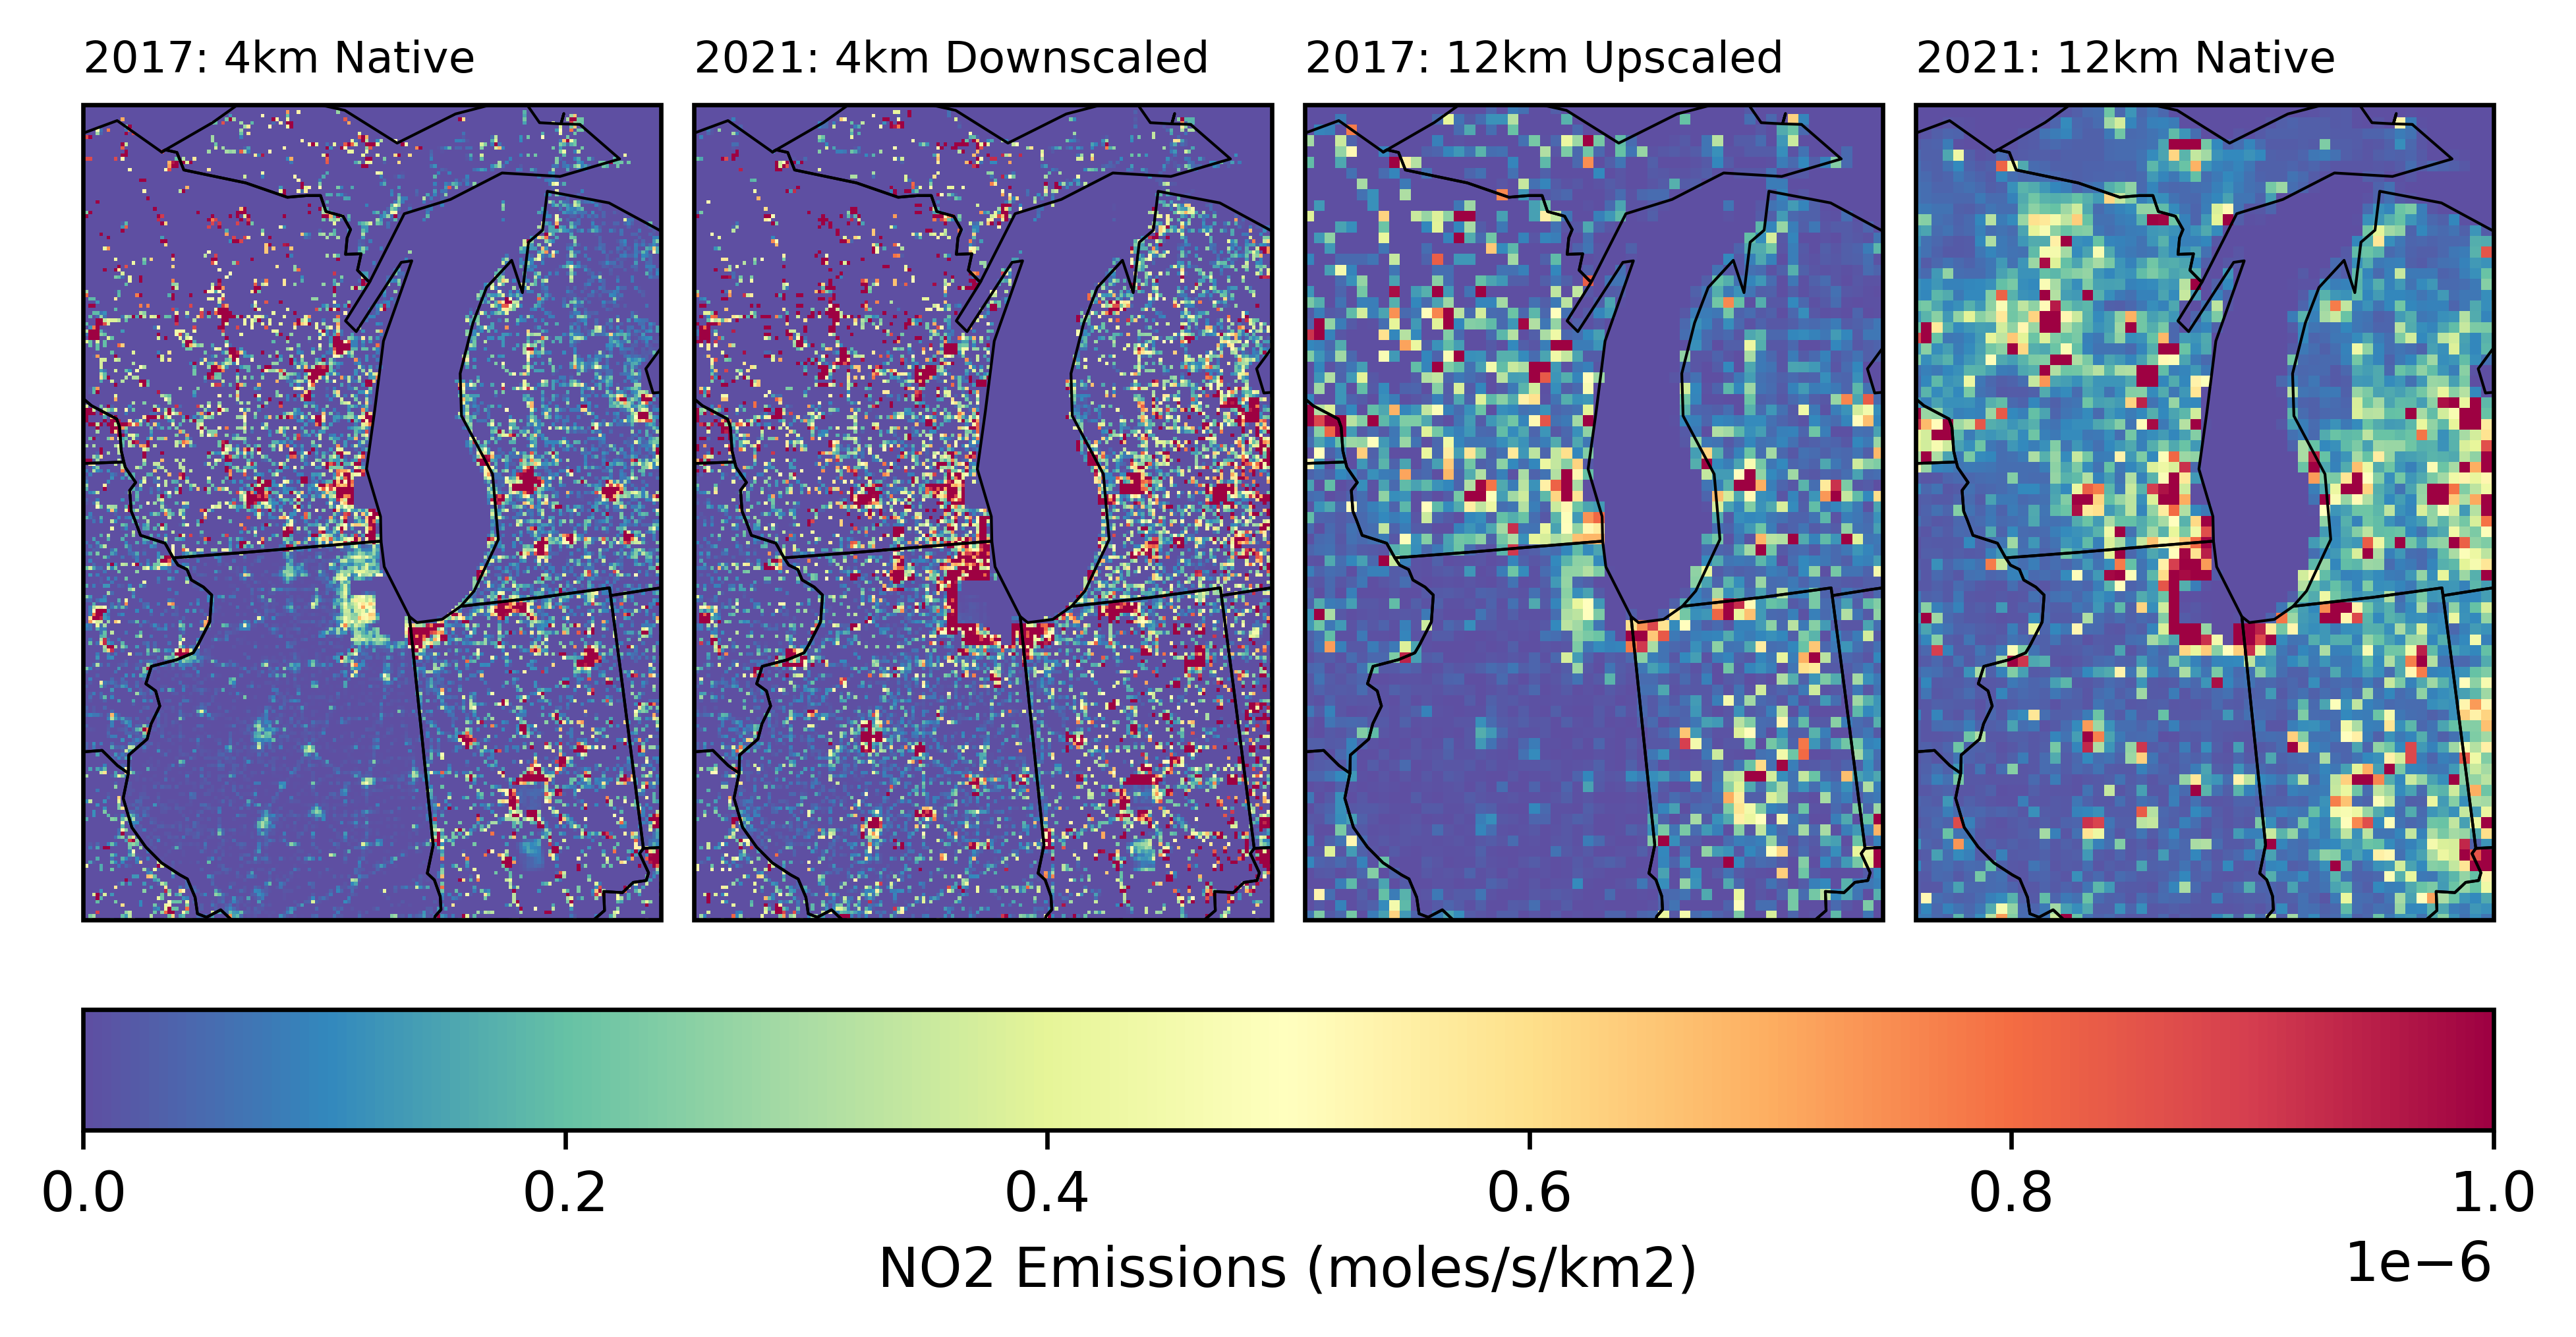

In [10]:
# =============================================================================
# Figure Specifications
# =============================================================================

# Area of 4km and 12km gridcells to calculate emission rate per sq km
area4k = 4 * 4
area12k = 12 * 12

itime = 0

# Colorbar specifications
cmap = "Spectral_r"
vmin = 0
vmax = 1e-6

extent = [da_fine.x.min(), da_fine.x.max(), da_fine.y.min(), da_fine.y.max()]

# =============================================================================
# Create the Figure
# =============================================================================

fig, axs = plt.subplots(
    ncols=4, subplot_kw=dict(projection=proj_fine), dpi=600, layout="constrained"
)

ax1, ax2, ax3, ax4 = axs

cs = ax1.pcolormesh(
    da_fine.x,
    da_fine.y,
    da_fine.isel(time=itime) / area4k,
    transform=proj_fine,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
)

ax2.pcolormesh(
    da_dscale.x,
    da_dscale.y,
    da_dscale.isel(time=itime) / area4k,
    transform=proj_fine,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
)

ax3.pcolormesh(
    da_upscale.x,
    da_upscale.y,
    da_upscale.isel(time=itime) / area12k,
    transform=proj_fine,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
)

ax4.pcolormesh(
    da_coarse.x,
    da_coarse.y,
    da_coarse.isel(time=itime) / area12k,
    transform=proj_coarse,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
)

# -----------------------------------------------------------------------------
# Add Colorbar, Titles, and Outlines of US States
# -----------------------------------------------------------------------------

cbar = fig.colorbar(cs, ax=axs, location="bottom")
cbar.set_label("NO2 Emissions (moles/s/km2)")

ax1.set_title("2017: 4km Native", fontsize=8, loc="left")
ax2.set_title("2021: 4km Downscaled", fontsize=8, loc="left")
ax3.set_title("2017: 12km Upscaled", fontsize=8, loc="left")
ax4.set_title("2021: 12km Native", fontsize=8, loc="left")

for ax in axs:
    ax.add_feature(cf.STATES.with_scale("110m"), linewidth=0.5)
    ax.set_extent(extent, crs=proj_fine)

plt.show()